#   CPOP package Vignette

## Introduction

The CPOP algorithm fits a change-in-slope model to data. It assumes that we have we have data points $(y_1,x_1),\ldots,(y_n,x_n)$, ordered so that $x_1<x_2<\cdots<x_n$. For example  $x_i$ could be a time-stamp of when response $y_i$ is obtained. We model the response, $y$, as a signal plus noise where the signal is modelled as a continuous piecewise linear function of $x$. That is

$$
y_i=f(x_i)+\epsilon_i
$$

where $f(x)$ is a continuous piecewise linear function.

To estimate the function $f(x)$ we specify a set of $N$ grid points, $g_{1:N}$ with these ordered so that $g_i<g_j$ if and only if $i<j$, and allow the slope of $f(x)$ to only change at these grid points. We then estimate the number of changes, the location of the changes, and hence the resulting function $f(x)$ by minimising a penalised weighted least squares criteria. This criteria includes a term which measures fit to the data, which is calculated as the sum of the square residuals of the fitted function, scaled by the variance of the noise. The penalty is proportional to the number of changes.

That is our estimated function will depend on $K$, the number of changes in slope, their locations, $\tau_1,\ldots,\tau_K$, and the value of the function $f(x)$ at these change points, $\alpha_1,\ldots,\alpha_K$, and its values, $\alpha_0$ at  $\tau_0<x_1$ and $\alpha_{K+1}$ at some $\tau_{K+1}>x_N$. The CPOP algorithm then estimates $K$, $\tau_{1:K}$ and $\alpha_{0:K+1}$ by as the values the solve the following minimisation problem

$$
\min_{K,\tau_{1:K}\in g_{1:N}, \alpha_{0:K+1} } \left\{
\sum_{i=1}^n \frac{1}{\sigma^2_i} (y_i -  \alpha_{j(i)}-(\alpha_{j(i)+1}-  \alpha_{j(i)})\frac{x_i-\tau_{j(i)}}{\tau_{j(i)+1}-\tau_{j(i)}})^2+K\beta
\right\},
$$

where $\sigma^2_1,\ldots,\sigma^2_n$ are the variances of the noise $\epsilon_i$ for $i=1,\ldots,n$, and $\beta$ is the penalty for adding a changepoint. The sum in this expression is the weighted residual sum of squares, and the $K\beta$ term is the penalty for having $K$ changes. 

If we know of have good estimates of the residual variances, and the noise is (close to) independent over time than an appropriate choice for the penalty is $\beta=2 \log n$, and this is the default for CPOP. However in many applications these assumptions will not hold and it is advised to look at segmentations for different value of $\beta$ -- this is possible using CPOP with the CROPS algorithm. Larger values of $\beta$ will lead to functions with fewer changes. Also there is a trade-off between the variances of the residuals and $\beta$: e.g. if we double the variances and half the value of $\beta$ we will obtain the same estimates for the number and location of the changes and the underlying function.


## Basic usage

The __cpop__ package contains a single function for applying the cpop method to a univariate time series. The following example demonstrates using cpop to analyse a simulated data using default values for the method parameters. 

### load the package

In [5]:
library(cpop)

Loading required package: crops

Registered S3 method overwritten by 'ggplot2':
  method        from
  print.element sets

Loading required package: pacman


Attaching package: ‘cpop’


The following objects are masked from ‘package:stats’:

    fitted, simulate


The following object is masked from ‘package:methods’:

    show




### generate some simluated data

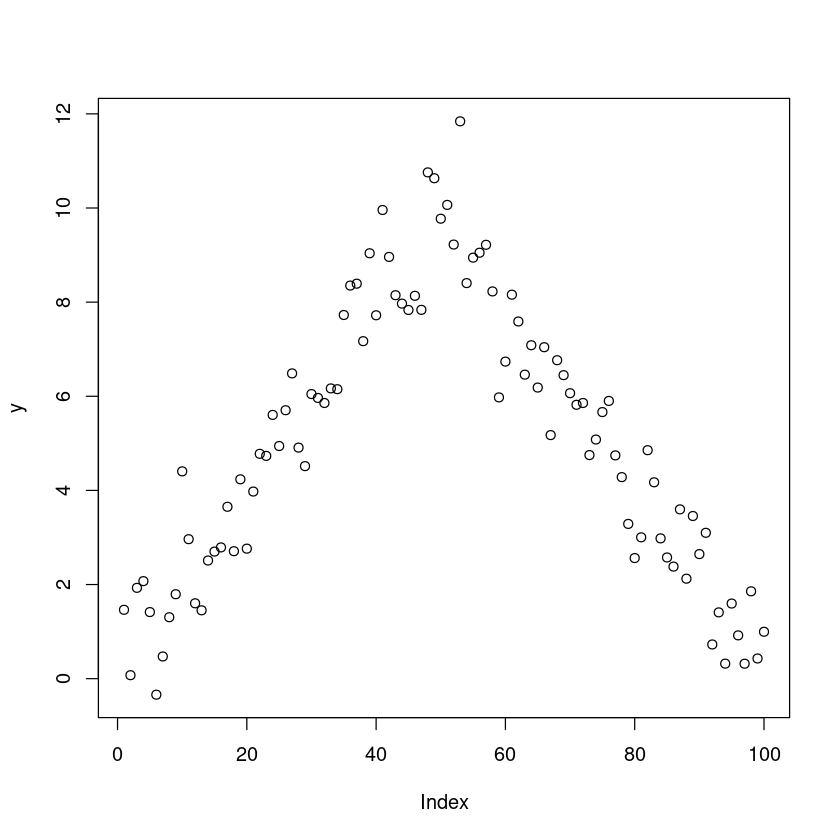

In [6]:
set.seed(0)
x <- 1:100
n <- length(x)
sigma <- rep(1.0,n)
mu <- 10*c(2*x[1:(n/2)]/n,2-2*x[((n/2)+1):n]/n)
y <- rnorm(n,mu,sigma)
plot(y)

### basic cpop analysis

In [7]:
res <- cpop(y)

### basic post processing 

The __cpop__ method returns an S4 class of type __cpop.class__ and number of S4 generic post-processing methods (plot, summary, and sonon ) are available in the __cpop__ package.

#### summary

A __summary__ method has been provided which details the changepoint locations, estimates for the gradient and intercept of the piecewise linear sections, the resulting residual sum of squares, and the penalised cost. 

In [8]:
summary(res)


cpop analysis with n = 100 and penalty (beta)  = 9.21034

1  changepoint detected at x = 
 49
fitted values : 
  x0        y0 x1        y1   gradient  intercept      RSS
1  0 0.3769332 49 9.8278009  0.1928749  0.3769332 41.00823
2 49 9.8278009 99 0.2497007 -0.1915620 19.2143391 34.80863

overall RSS = 75.81686
cost = 85.0272



The output of the __summary__ method indicates the location of the changepoints and the details of the fitted line segments in terms of the end points of the segments $(x_{0},y_{0})$ and $(x_{0},y_{0})$ and the gradient / intercept for each segment. It also includes the residual sum of squares for each fitted segment.

#### plot

The __plot__ function is provided for creating a __ggplo2__ opbject which can be used to display the fit and changepoint locations.

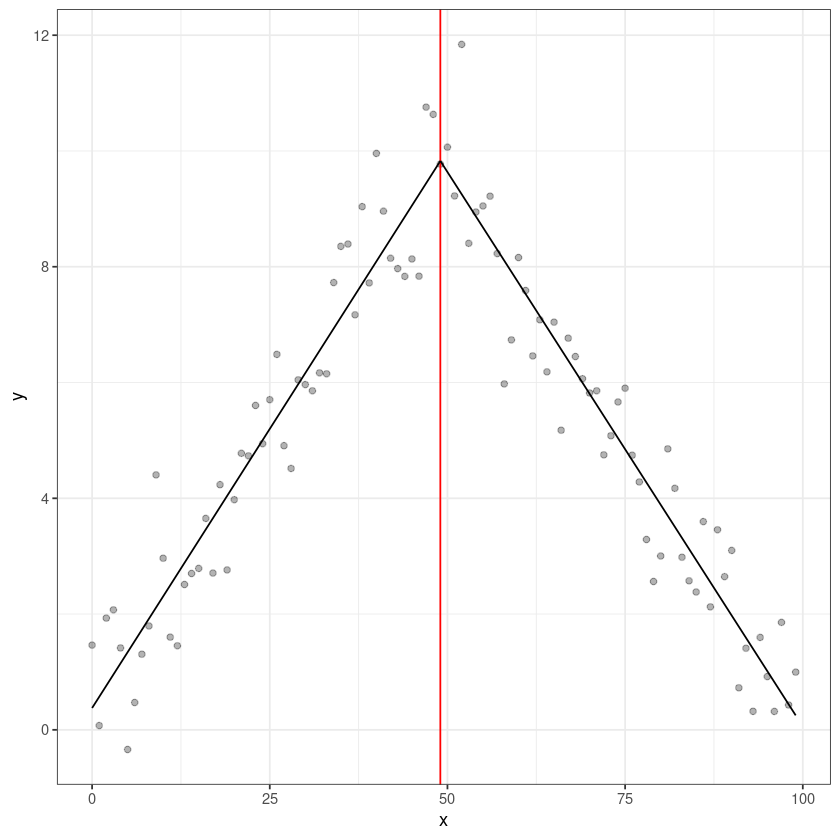

In [9]:
plot(res)

#### fitted

The values for the endpoints, gradients, intercepts and RSS for each line segment (as shown using the __summary__ method) can be obtained as a data frame using the __fitted__ method.  

In [13]:
df <- fitted(res)
print(df)

  x0        y0 x1        y1   gradient  intercept      RSS
1  0 0.3769332 49 9.8278009  0.1928749  0.3769332 41.00823
2 49 9.8278009 99 0.2497007 -0.1915620 19.2143391 34.80863


#### estimate

The resulting S4 class produced by __cpop__ can be used to estimate the fitted model at specified points. The results from __estimate__ are available as a data frame containing the location and estimated value. Note, __estimate__ will extrapolate the fitted model outside of the range of the initial data.

In [19]:
estimate(res,x = c(2.7,51.5,150))

x,y_hat
<dbl>,<dbl>
2.7,0.3769332
51.5,8.8281338
150.0,-10.0407235


#### residuals

A matrix of residuals for a model fitted by __cpop__ can obtained by applying the __residuals__ method to a result produced by __cpop__.  

In [23]:
head(residuals(res))

1.0860211
-0.4960414
1.1671163
1.1168716
0.2662088
-1.6812575


#### changepoints

The locations of the changepoints associated with a __cpop__ model can be obtained as a data frame using __changepoints__.

In [38]:
changepoints(res)

location
<dbl>
49


#### cost

The penalised cost of a __cpop__ model is obtained using the __cost__ method. The value returned by __cost__ is the the sum of the residuals for each segment plus $k\beta$ where $k$ is the number of changepoints and $\beta$ the penalty for fitting a changepoint. 

In [25]:
cost(res)

[1] 85.0272

Which is equivalent to 

In [41]:
sum(residuals(res)*residuals(res)) + length(changepoints(res))*res@beta

[1] 85.0272

## cpop paramaters

In [1]:
library(cpop)

Loading required package: crops

Registered S3 method overwritten by 'ggplot2':
  method        from
  print.element sets

Loading required package: pacman


Attaching package: ‘cpop’


The following objects are masked from ‘package:stats’:

    fitted, simulate


The following object is masked from ‘package:methods’:

    show


